In [1]:
import os
root_dir = '/home/tim/Dropbox/experimental/' # your path here where to parent directory where repos are
os.chdir(root_dir)
import map_data.map_methods as mm
import supervised_learning.supervised_methods as sm
import utils.global_methods as gm
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
#markers = list(Line2D.markers.keys())
markers = ['o', 'P', 'X', '^', '1', 's', 'p', '*', 'D']
import numpy as np
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())

cpu count: 20
gpu count: 2
cuda avail: True


In [2]:
version_names = {
    'V1':'static',
    #'V2':'slim no kd',
    'V3':'slim vanilla',
    #'V4':'slim soft kd',
    #'V5':'slim SGD',
    #'V6':'slim SGD L1',
    #'V7':'slim L1',
    'V8':'slim scaled rate',
    'V9':'static decayed rate',
    'V10':'slim scaled+decayed rate',
}

seed_dirs = []
seed_params = []
seed_r2s = []
for version_name in version_names:
    version_dir = f'models/monocular_depth/{version_name}/'
    for scale_name in os.listdir(version_dir):
        scale_dir = f'{version_dir}{scale_name}/'
        for seed_name in os.listdir(scale_dir):
            seed_dir = f'{scale_dir}{seed_name}/'
            params_path = f'{seed_dir}params.p'
            r2s_path = f'{seed_dir}r2s.p'
            if not os.path.exists(r2s_path) or not os.path.exists(params_path):
                continue
            seed_dirs.append(seed_dir)
            seed_params.append(gm.pk_read(params_path))
            seed_r2s.append(gm.pk_read(r2s_path))
print(len(seed_dirs), 'models')

143 models


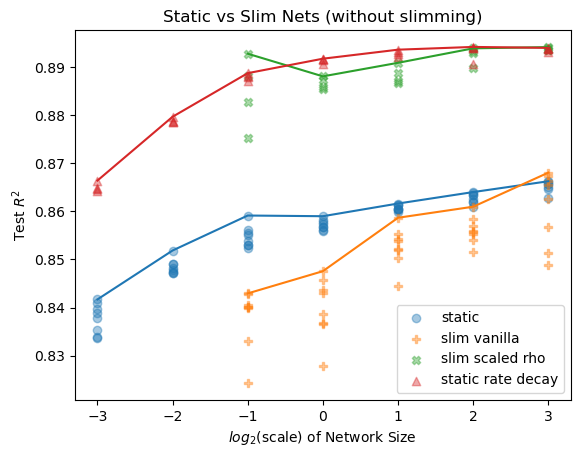

In [3]:
data_key = 'Static vs Slim Nets (without slimming)'
data = {
    data_key:{'values':{},'xlabel':r'$log_2$(scale) of Network Size','ylabel':r'Test $R^2$'},
}
for title in data:
    for version_name in version_names:
        data[title]['values'][version_names[version_name]] = {'xs':[], 'ys':[]}
for idx in range(len(seed_dirs)):
    model_dir = seed_dirs[idx]
    model_params = seed_params[idx]
    model_r2s = seed_r2s[idx]
    slimmable = model_params['use_slim_cnn']
    version_name = model_params['version'][:2]
    max_scale = model_params['scale']
    if slimmable:
        r2 = model_r2s['test'][1]
    else:
        r2 = model_r2s['test']
    data[data_key]['values'][version_names[version_name]]['xs'].append(max_scale)
    data[data_key]['values'][version_names[version_name]]['ys'].append(r2)
for title in data:
    plt.title(title)
    plt.xlabel(data[title]['xlabel'])
    plt.ylabel(data[title]['ylabel'])
    for i, label in enumerate(data[title]['values']):
        xs, ys = data[title]['values'][label]['xs'], data[title]['values'][label]['ys']
        plt.scatter(np.log2(xs), ys, alpha=0.4, label=label, marker=markers[i])
        data_dict = {x:[] for x in xs}
        for j in range(len(xs)):
            x, y = xs[j], ys[j]
            data_dict[x].append(y)
        max_xs = [x for x in data_dict]
        max_xs.sort()
        max_ys = [np.max(data_dict[x]) for x in max_xs]
        plt.plot(np.log2(max_xs), max_ys)
        data[title]['values'][label]['max_xs'] = max_xs
        data[title]['values'][label]['max_ys'] = max_ys
    plt.legend()
    plt.show()

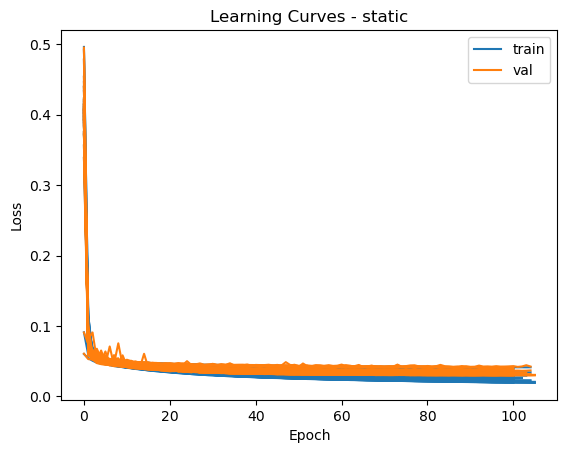

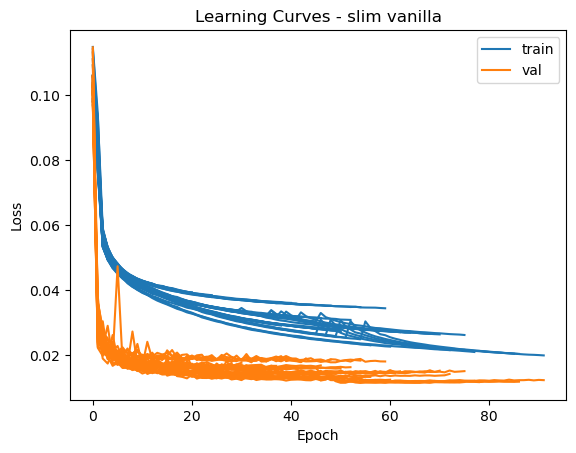

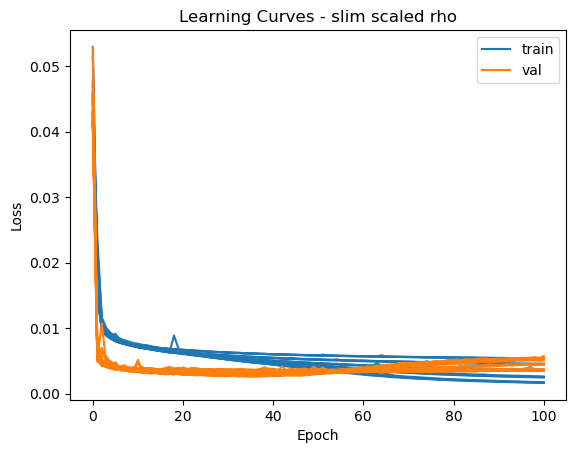

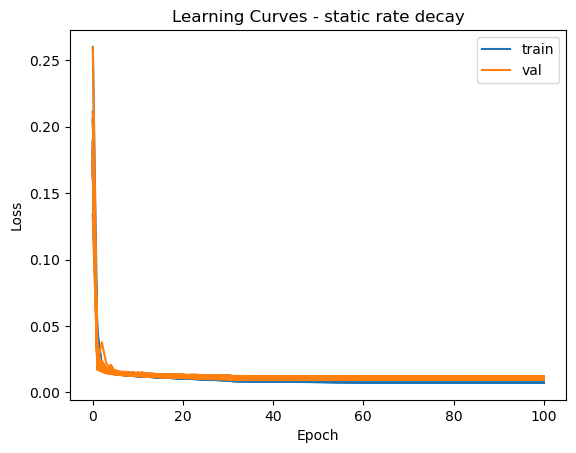

{'static': [99, 84, 99, 99, 97, 103, 97, 99, 99, 99, 95, 99, 99, 103, 97, 99, 99, 95, 99, 72, 99, 101, 99, 99, 103, 104, 99, 99, 104, 99, 99, 99, 98, 97, 99, 99, 104, 99, 99, 99, 99, 99, 99, 99, 102, 99, 99, 84, 99, 79, 72, 99, 103, 70, 95], 'slim vanilla': [60, 58, 61, 67, 49, 74, 69, 63, 51, 36, 27, 20, 45, 29, 41, 31, 90, 84, 76, 59, 71, 85, 55, 74, 41, 48, 49, 37, 46, 49, 45, 34, 42, 23, 19, 53, 40, 58, 47, 39], 'slim scaled rho': [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99], 'static rate decay': [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]}


In [4]:
train_curves = {version_names[version_name]:[] for version_name in version_names}
val_curves = {version_names[version_name]:[] for version_name in version_names}
Ns = {version_names[version_name]:[] for version_name in version_names}
for idx in range(len(seed_dirs)):
    model_dir = seed_dirs[idx]
    model_params = seed_params[idx]
    version_name = model_params['version'][:2]
    max_scale = model_params['scale']
    train_metrics = gm.read_json(f'{model_dir}train_metrics.json')
    train_curve = train_metrics['train_losses']
    val_curve = train_metrics['val_losses']
    vkey = version_names[version_name]
    N = train_metrics['n_epochs']
    train_curves[vkey].append(train_curve)
    val_curves[vkey].append(val_curve)
    Ns[vkey].append(N)

for i, version_name in enumerate(version_names):
    vkey = version_names[version_name]
    for j, train_curve in enumerate(train_curves[vkey]):
        if j == 0:
            plt.plot(train_curve, color=colors[0], label='train')
        else:
            plt.plot(train_curve, color=colors[0],)
    for j, val_curve in enumerate(val_curves[vkey]):
        if j == 0:
            plt.plot(val_curve, color=colors[1], label='val')
        else:
            plt.plot(val_curve, color=colors[1], )
    plt.title(f'Learning Curves - {vkey}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
print(Ns)

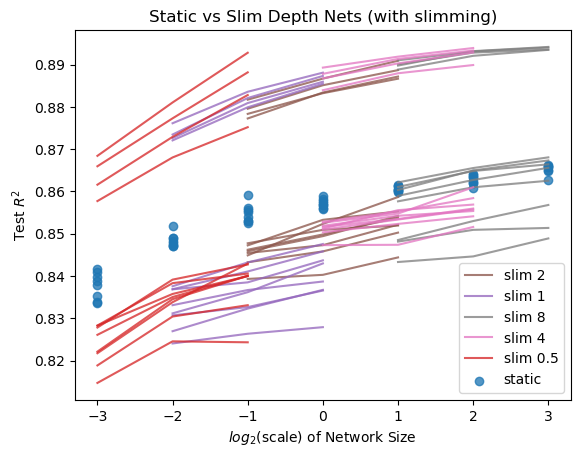

In [5]:
color_map = {
    0.125:colors[1],
    0.25:colors[2],
    0.5:colors[3],
    1:colors[4],
    2:colors[5],
    4:colors[6],
    8:colors[7],
}
labeled = []
for idx in range(len(seed_dirs)):
    model_dir = seed_dirs[idx]
    model_params = seed_params[idx]
    model_r2s = seed_r2s[idx]
    slimmable = model_params['use_slim_train']
    version_name = model_params['version'][:2]
    max_scale = model_params['scale']
    if slimmable:
        rhos = model_params['rhos']
        #r2s = [model_r2s['test'][rho] for rho in rhos]
        scales = []
        r2s = []
        for rho in rhos:
            scales.append(np.log2(rho*max_scale))
            r2s.append(model_r2s['test'][rho])
        if max_scale not in labeled:
            plt.plot(scales, r2s, color=color_map[max_scale], alpha=0.77, label=f'slim {max_scale}')
            labeled.append(max_scale)
        else:
            plt.plot(scales, r2s, alpha=0.77, color=color_map[max_scale])
#plt.plot(np.log10(data['Scale vs Depth Error']['values']['static']['max_xs']), 
#         data['Scale vs Depth Error']['values']['static']['max_ys'], label='static', color=colors[0])
xs = data[data_key]['values']['static']['xs']
ys = data[data_key]['values']['static']['ys']
plt.scatter(np.log2(xs), ys, alpha=0.77, label='static', color=colors[0])
plt.legend()
scales = list(color_map.keys())
#plt.xticks([np.log2(scale) for scale in scales], [f'log2({scale})' for scale in scales], rotation=45)
plt.xlabel(r'$log_2$(scale) of Network Size')
plt.title('Static vs Slim Depth Nets (with slimming)')
plt.ylabel(r'Test $R^2$')
plt.show()